# Accelerated Parameter Mapping of Multiple-Echo Gradient-Echo Data Using Model-Based Iterative Reconstruction

*M. Zimmermann, Z. Abbas, K. Dzieciol and N. J. Shah, "Accelerated Parameter Mapping of Multiple-Echo Gradient-Echo Data Using Model-Based Iterative Reconstruction," in IEEE Transactions on Medical Imaging, vol. 37, no. 2, pp. 626-637, Feb. 2018, doi: 10.1109/TMI.2017.2771504.*

# Load data

In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os
import sys

sys.path.insert(0, "../src")

import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch

from juart.conopt.functional.fourier import nonuniform_fourier_transform_adjoint
from juart.conopt.tfs.fourier import nonuniform_transfer_function
from juart.recon.mirage import MIRAGE
from juart.recon.monitoring import ConvergenceMonitor
from juart.vis import MultiPlotter

torch.set_num_threads(16)
torch.set_grad_enabled(False)

torch.autograd.grad_mode.set_grad_enabled(mode=False)

## Load sequence parameters

In [2]:
with h5py.File(os.path.join('..', 'LocalData', 'Simulations', 'mege_info.h5'), 'r') as f:
    num_spokes = f['num_spokes'][...]
    num_echoes = f['num_echoes'][...]
    num_partitions_per_block = f['num_partitions_per_block'][...]
    num_autocalibration_lines = f['num_autocalibration_lines'][...]
    acceleration_factor = f['acceleration_factor'][...]
    matrix_size = f['matrix_size'][...]
    readout_bandwidth = f['readout_bandwidth'][...]
    dTE = f['dTE'][...]
    TE0 = f['TE0'][...]

In [3]:
nUS = num_spokes
iS = matrix_size[2]//2 - 1
# iS = 0

print(f"Number of spokes: {nUS}")
print(f"Center slice number: {iS}")

Number of spokes: 32
Center slice number: 5


In [8]:
filepath = '/workspaces/juart-dev'
# filepath = '/home/jovyan/juart-dev'
h5_preproc_fname = os.path.join('LocalData', 'Simulations','mege_grappa_pytorch.h5')
h5_image_fname =  os.path.join('LocalData', 'Simulations','mz_me_mpnrage3d_grappa_%s_%s.h5' % (iS, nUS))

In [9]:
full_h5_preproc_fname = os.path.join(filepath, h5_preproc_fname)
full_h5_image_fname = os.path.join(filepath, h5_image_fname)

In [10]:
print(full_h5_preproc_fname)
print(full_h5_image_fname)

/workspaces/juart-dev/LocalData/Simulations/mege_grappa_pytorch.h5
/workspaces/juart-dev/LocalData/Simulations/mz_me_mpnrage3d_grappa_5_32.h5


In [11]:
with h5py.File(
    full_h5_preproc_fname,
    "r",
    libver="latest",
    swmr=True,
) as h5_preproc_file:
    nC, nX, nY, nZ, nS = h5_preproc_file["C"].shape[:5]
    nC, spokes, baseresolution, nZ, nS, nTI, nTE = h5_preproc_file["d"].shape

    shape = (nX, nY, nZ, 1, nTI, nTE)

    print("Reconstructing slice %s of %s." % (iS, nS))

    nK = baseresolution * nUS

    # Read data
    C = h5_preproc_file["C"][:, :, :, :, iS : iS + 1, :, :]
    k = h5_preproc_file["k"][:, :nUS, :, :, :, :, :]
    d = h5_preproc_file["d"][:, :nUS, :, :, iS : iS + 1, :, :] / 1e3 / 50

    # nC = 1

    k = k.reshape((2, nK, 1, nTI, nTE))
    d = d.reshape((nC, nK, 1, nTI, nTE))

    C = torch.tensor(C, dtype=torch.complex64)
    k = torch.tensor(k, dtype=torch.float32)
    d = torch.tensor(d, dtype=torch.complex64)

Reconstructing slice 5 of 12.


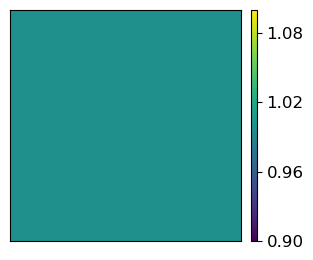

In [12]:
MultiPlotter(
    np.abs(C[..., 0, 0].numpy()),
    (1, nC),
    axis=0,
    fig=plt.figure(figsize=(10, 3)),
    cbar_size="2.5%",
    cbar_pad=0.1,
)

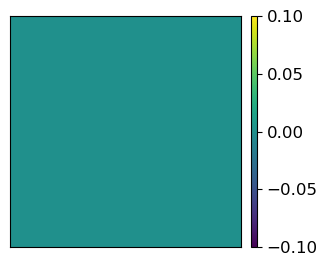

In [13]:
MultiPlotter(
    np.angle(C[..., 0, 0].numpy()),
    (1, nC),
    axis=0,
    fig=plt.figure(figsize=(10, 3)),
    cbar_size="2.5%",
    cbar_pad=0.1,
)

In [14]:
AHd = nonuniform_fourier_transform_adjoint(
    k,
    d,
    (nX, nY),
    modeord=0,
    isign=1,
)
AHd = torch.sum(torch.conj(C) * AHd, dim=0)

In [15]:
H = nonuniform_transfer_function(k, (1, nX, nY, nZ, 1, nTI, nTE), oversampling=(2, 2))

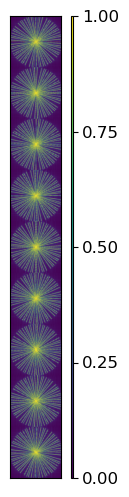

In [16]:
MultiPlotter(
    np.abs(H[0, :, :, 0, 0, :, :].numpy()),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="viridis",
    vmin=0,
    vmax=1,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

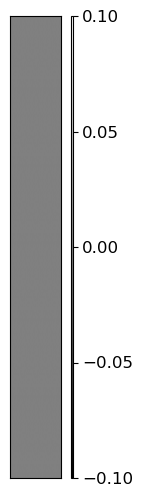

In [17]:
MultiPlotter(
    np.abs(AHd[:, :, 0, 0, :, :].numpy()),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="gray",
#     vmin=0,
#     vmax=0.0125,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

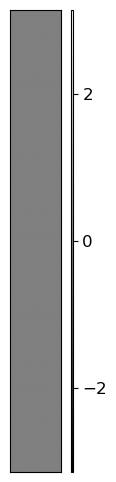

In [18]:
MultiPlotter(
    np.angle(AHd[..., 0, 0, :, :].numpy()),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="gray",
    vmin=-np.pi,
    vmax=np.pi,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

In [19]:
support = torch.abs(C).max(dim=0).values > 0

cm = ConvergenceMonitor(support + torch.zeros(shape), support, logfile=None)

solver = MIRAGE(
    C[..., 0, 0],
    AHd,
    H,
    lambda_wavelet=1e-3,
    lambda_hankel=None,
    lambda_casorati=None,
    weight_wavelet=1,
    weight_hankel=0.5,
    weight_casorati=0.5,
    cg_maxiter=5,
    admm_maxiter=30,
    callback=cm.callback,
)

[Convergence Monitor] Initialization complete.


In [20]:
# Run MIRAGE reconstruction
solver.solve()

[ADMM] Iter: 00 Prim Res: NAN Dual Res: NAN Rel Res: NAN:   3%|▎         | 1/30 [00:00<00:12,  2.31it/s]

[Convergence Monitor] Norm:        nan 	 Time per Iteration:  0.000e+00


[ADMM] Iter: 01 Prim Res: NAN Dual Res: NAN Rel Res: NAN:   7%|▋         | 2/30 [00:00<00:11,  2.37it/s]

[Convergence Monitor] Norm:        nan 	 Time per Iteration:  4.129e-01


[ADMM] Iter: 02 Prim Res: NAN Dual Res: NAN Rel Res: NAN:  10%|█         | 3/30 [00:01<00:11,  2.38it/s]

[Convergence Monitor] Norm:        nan 	 Time per Iteration:  4.175e-01


[ADMM] Iter: 03 Prim Res: NAN Dual Res: NAN Rel Res: NAN:  13%|█▎        | 4/30 [00:01<00:11,  2.35it/s]

[Convergence Monitor] Norm:        nan 	 Time per Iteration:  4.374e-01


[ADMM] Iter: 04 Prim Res: NAN Dual Res: NAN Rel Res: NAN:  17%|█▋        | 5/30 [00:02<00:10,  2.35it/s]

[Convergence Monitor] Norm:        nan 	 Time per Iteration:  4.260e-01


[ADMM] Iter: 05 Prim Res: NAN Dual Res: NAN Rel Res: NAN:  20%|██        | 6/30 [00:02<00:10,  2.33it/s]

[Convergence Monitor] Norm:        nan 	 Time per Iteration:  4.333e-01


[ADMM] Iter: 06 Prim Res: NAN Dual Res: NAN Rel Res: NAN:  23%|██▎       | 7/30 [00:02<00:09,  2.33it/s]

[Convergence Monitor] Norm:        nan 	 Time per Iteration:  4.321e-01


[ADMM] Iter: 07 Prim Res: NAN Dual Res: NAN Rel Res: NAN:  27%|██▋       | 8/30 [00:03<00:09,  2.32it/s]

[Convergence Monitor] Norm:        nan 	 Time per Iteration:  4.347e-01


[ADMM] Iter: 08 Prim Res: NAN Dual Res: NAN Rel Res: NAN:  30%|███       | 9/30 [00:03<00:09,  2.33it/s]

[Convergence Monitor] Norm:        nan 	 Time per Iteration:  4.272e-01


[ADMM] Iter: 09 Prim Res: NAN Dual Res: NAN Rel Res: NAN:  33%|███▎      | 10/30 [00:04<00:08,  2.32it/s]

[Convergence Monitor] Norm:        nan 	 Time per Iteration:  4.326e-01


[ADMM] Iter: 10 Prim Res: NAN Dual Res: NAN Rel Res: NAN:  37%|███▋      | 11/30 [00:04<00:08,  2.33it/s]

[Convergence Monitor] Norm:        nan 	 Time per Iteration:  4.228e-01


[ADMM] Iter: 11 Prim Res: NAN Dual Res: NAN Rel Res: NAN:  40%|████      | 12/30 [00:05<00:07,  2.34it/s]

[Convergence Monitor] Norm:        nan 	 Time per Iteration:  4.270e-01


[ADMM] Iter: 12 Prim Res: NAN Dual Res: NAN Rel Res: NAN:  43%|████▎     | 13/30 [00:05<00:07,  2.36it/s]

[Convergence Monitor] Norm:        nan 	 Time per Iteration:  4.147e-01


[ADMM] Iter: 13 Prim Res: NAN Dual Res: NAN Rel Res: NAN:  47%|████▋     | 14/30 [00:05<00:06,  2.37it/s]

[Convergence Monitor] Norm:        nan 	 Time per Iteration:  4.177e-01


[ADMM] Iter: 14 Prim Res: NAN Dual Res: NAN Rel Res: NAN:  50%|█████     | 15/30 [00:06<00:06,  2.38it/s]

[Convergence Monitor] Norm:        nan 	 Time per Iteration:  4.156e-01


[ADMM] Iter: 15 Prim Res: NAN Dual Res: NAN Rel Res: NAN:  53%|█████▎    | 16/30 [00:06<00:05,  2.38it/s]

[Convergence Monitor] Norm:        nan 	 Time per Iteration:  4.186e-01


[ADMM] Iter: 16 Prim Res: NAN Dual Res: NAN Rel Res: NAN:  57%|█████▋    | 17/30 [00:07<00:05,  2.35it/s]

[Convergence Monitor] Norm:        nan 	 Time per Iteration:  4.358e-01


[ADMM] Iter: 17 Prim Res: NAN Dual Res: NAN Rel Res: NAN:  60%|██████    | 18/30 [00:07<00:05,  2.38it/s]

[Convergence Monitor] Norm:        nan 	 Time per Iteration:  4.101e-01


[ADMM] Iter: 18 Prim Res: NAN Dual Res: NAN Rel Res: NAN:  63%|██████▎   | 19/30 [00:08<00:04,  2.38it/s]

[Convergence Monitor] Norm:        nan 	 Time per Iteration:  4.171e-01


[ADMM] Iter: 19 Prim Res: NAN Dual Res: NAN Rel Res: NAN:  67%|██████▋   | 20/30 [00:08<00:04,  2.39it/s]

[Convergence Monitor] Norm:        nan 	 Time per Iteration:  4.144e-01


[ADMM] Iter: 20 Prim Res: NAN Dual Res: NAN Rel Res: NAN:  70%|███████   | 21/30 [00:08<00:03,  2.40it/s]

[Convergence Monitor] Norm:        nan 	 Time per Iteration:  4.157e-01


[ADMM] Iter: 21 Prim Res: NAN Dual Res: NAN Rel Res: NAN:  73%|███████▎  | 22/30 [00:09<00:03,  2.40it/s]

[Convergence Monitor] Norm:        nan 	 Time per Iteration:  4.135e-01


[ADMM] Iter: 22 Prim Res: NAN Dual Res: NAN Rel Res: NAN:  77%|███████▋  | 23/30 [00:09<00:02,  2.40it/s]

[Convergence Monitor] Norm:        nan 	 Time per Iteration:  4.185e-01


[ADMM] Iter: 23 Prim Res: NAN Dual Res: NAN Rel Res: NAN:  80%|████████  | 24/30 [00:10<00:02,  2.40it/s]

[Convergence Monitor] Norm:        nan 	 Time per Iteration:  4.157e-01


[ADMM] Iter: 24 Prim Res: NAN Dual Res: NAN Rel Res: NAN:  83%|████████▎ | 25/30 [00:10<00:02,  2.40it/s]

[Convergence Monitor] Norm:        nan 	 Time per Iteration:  4.161e-01


[ADMM] Iter: 25 Prim Res: NAN Dual Res: NAN Rel Res: NAN:  87%|████████▋ | 26/30 [00:10<00:01,  2.39it/s]

[Convergence Monitor] Norm:        nan 	 Time per Iteration:  4.213e-01


[ADMM] Iter: 26 Prim Res: NAN Dual Res: NAN Rel Res: NAN:  90%|█████████ | 27/30 [00:11<00:01,  2.37it/s]

[Convergence Monitor] Norm:        nan 	 Time per Iteration:  4.291e-01


[ADMM] Iter: 27 Prim Res: NAN Dual Res: NAN Rel Res: NAN:  93%|█████████▎| 28/30 [00:11<00:00,  2.35it/s]

[Convergence Monitor] Norm:        nan 	 Time per Iteration:  4.335e-01


[ADMM] Iter: 28 Prim Res: NAN Dual Res: NAN Rel Res: NAN:  97%|█████████▋| 29/30 [00:12<00:00,  2.37it/s]

[Convergence Monitor] Norm:        nan 	 Time per Iteration:  4.184e-01


[ADMM] Iter: 29 Prim Res: NAN Dual Res: NAN Rel Res: NAN: 100%|██████████| 30/30 [00:12<00:00,  2.36it/s]

[Convergence Monitor] Norm:        nan 	 Time per Iteration:  4.409e-01


tensor([nan, nan, nan,  ..., nan, nan, nan])

In [21]:
z_image = solver.solver.results["v"].view(torch.complex64).reshape(shape)

/tmp/ipykernel_10825/2121847719.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  np.abs(z_image[..., 0, 0, :, :]),


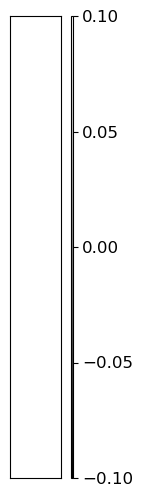

In [22]:
MultiPlotter(
    np.abs(z_image[..., 0, 0, :, :]),
    (nTE, nTI),
    axis=(3, 2),
    fig=plt.figure(figsize=(10, 6)),
    cmap="gray",
#     vmin=0,
#     vmax=20,
    cbar_size="2.5%",
    cbar_pad=0.1,
)

In [23]:
with h5py.File(full_h5_image_fname, "w", libver='latest') as h5_preproc_file:
    dset = h5_preproc_file.create_dataset("x", data=z_image, chunks=(nX, nY, nZ, 1, 1, 1))

In [24]:
# plt.savefig(os.path.join(filepath, 'reconstruction_MR0.png'), dpi=1200, transparent=True)